### Imports

In [1]:
from data_process.data import Data
from data_process.signal_tools import signal_filter, signal_transform
from data_process.utils import figure_reset_scale, get_by_path
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import numpy as np
%matplotlib widget

### Load and filter data

In [2]:
pickle_file = '/home/ntkot/theses/ros/bag_db/data_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10/rosbag2_07_10_2023__17_42_10.pkl'

original_data = Data(pickle_file)

sample_rate = 1 / np.average(original_data['time']['rel'][1:] - original_data['time']['rel'][0:-1])
print(f'Sample rate: {sample_rate:.3f}Hz')

accel_wiener_window = 21
accel_highpass_order = 3
accel_highpass_critical_frequency = 3

gyro_wiener_window = 21
gyro_highpass_order = 3
gyro_highpass_critical_frequency = 3

accel_wiener = lambda x: signal_filter.wiener(x, accel_wiener_window)
gyro_wiener  = lambda x: signal_filter.wiener(x, gyro_wiener_window)

accel_filter = lambda x: signal_filter.butterworth(signal=x, 
                                                   sample_rate=sample_rate, 
                                                   order=accel_highpass_order,
                                                   critical_freq=accel_highpass_critical_frequency,
                                                   btype='highpass')
gyro_filter  = lambda x: signal_filter.butterworth(signal=x, 
                                                   sample_rate=sample_rate, 
                                                   order=gyro_highpass_order, 
                                                   critical_freq=gyro_highpass_critical_frequency,
                                                   btype='highpass')

wiener_data = original_data.transform(accel_wiener, [['accel', 'x'], ['accel', 'y'], ['accel', 'z']])
wiener_data.transform(gyro_wiener,  [['gyro', 'x'],  ['gyro', 'y'],  ['gyro', 'z']], in_place=True)

filtered_data = wiener_data.transform(accel_filter, [['accel', 'x'], ['accel', 'y'], ['accel', 'z']])
filtered_data.transform(gyro_filter,  [['gyro', 'x'],  ['gyro', 'y'],  ['gyro', 'z']], in_place=True)

envelope_fun = lambda x: np.abs(signal_transform.hilbert(x))
enveloped_data = filtered_data.transform(envelope_fun,  [['accel', 'x'], ['accel', 'y'], ['accel', 'z'],
                                                         ['gyro', 'x'],  ['gyro', 'y'],  ['gyro', 'z']], in_place=False)

normalize_mean_std_fun = lambda x: (x - np.average(x)) / np.std(x)
norm_envelope_data = enveloped_data.transform(normalize_mean_std_fun, [['accel', 'x'], ['accel', 'y'], ['accel', 'z'],
                                                                       ['gyro',  'x'],  ['gyro', 'y'],  ['gyro', 'z']], in_place=False)

data_dict = {'original': original_data, 'wiener': wiener_data, 'filtered': filtered_data, 'envelope': enveloped_data}

Loading from pickle file...
Sample rate: 99.949Hz


### Before vs After filtering

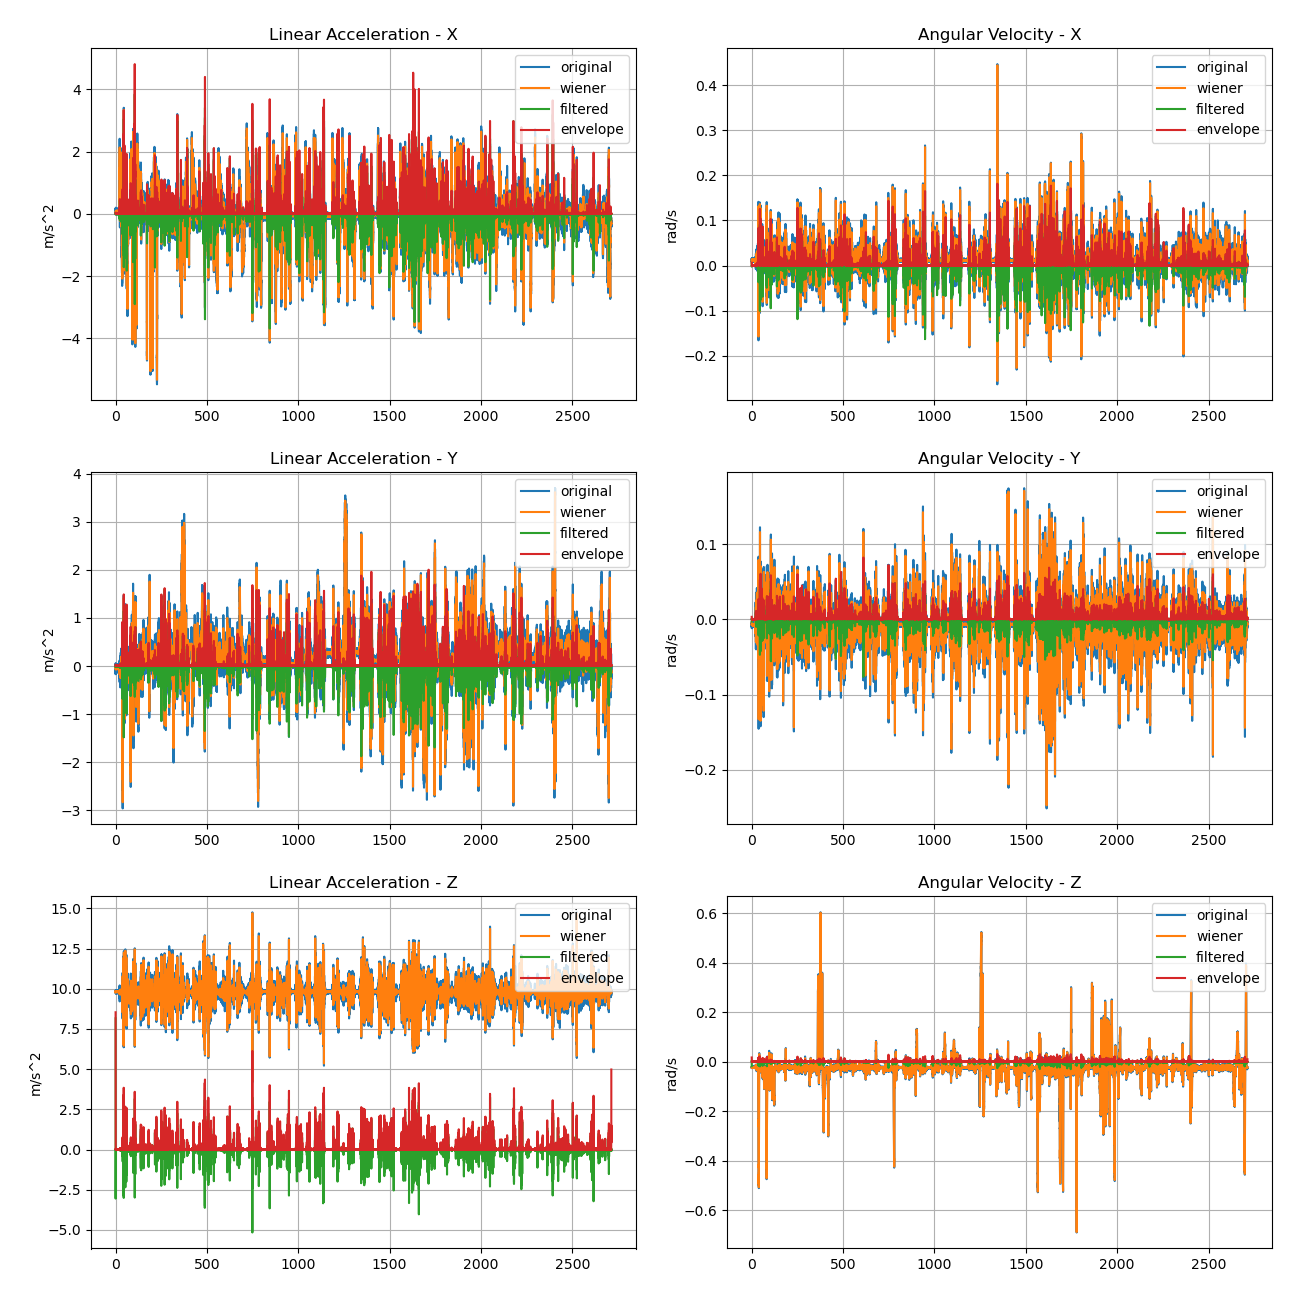

In [3]:
# If figure was created before, keep same x/y axis limits to allow for fast comparisons in time segments
filter_ax_x_lim = None
filter_ax_y_lim = None
if 'filter_ax' in locals():
    filter_ax_x_lim = filter_ax[0][0].get_xlim()
    filter_ax_y_lim = filter_ax[0][0].get_ylim()

filter_fig = plt.figure(1)
filter_fig.clear()
filter_fig, filter_ax = plt.subplots(num=1, nrows=3, ncols=2, sharex='all')

for key in data_dict.keys():
    filter_ax[0][0].plot(data_dict[key]['time']['rel'], data_dict[key]['accel']['x'], label=key)
filter_ax[0][0].grid(which='both', axis='both')
filter_ax[0][0].legend(loc='upper right')
filter_ax[0][0].tick_params(labelbottom=True)
filter_ax[0][0].set_ylabel('m/s^2')
filter_ax[0][0].set_title('Linear Acceleration - X')

for key in data_dict.keys():
    filter_ax[1][0].plot(data_dict[key]['time']['rel'], data_dict[key]['accel']['y'], label=key)
filter_ax[1][0].grid(which='both', axis='both')
filter_ax[1][0].legend(loc='upper right')
filter_ax[1][0].tick_params(labelbottom=True)
filter_ax[1][0].set_ylabel('m/s^2')
filter_ax[1][0].set_title('Linear Acceleration - Y')

for key in data_dict.keys():
    filter_ax[2][0].plot(data_dict[key]['time']['rel'], data_dict[key]['accel']['z'], label=key)
filter_ax[2][0].grid(which='both', axis='both')
filter_ax[2][0].legend(loc='upper right')
filter_ax[2][0].tick_params(labelbottom=True)
filter_ax[2][0].set_ylabel('m/s^2')
filter_ax[2][0].set_title('Linear Acceleration - Z')

for key in data_dict.keys():
    filter_ax[0][1].plot(data_dict[key]['time']['rel'], data_dict[key]['gyro']['x'], label=key)
filter_ax[0][1].grid(which='both', axis='both')
filter_ax[0][1].legend(loc='upper right')
filter_ax[0][1].tick_params(labelbottom=True)
filter_ax[0][1].set_ylabel('rad/s')
filter_ax[0][1].set_title('Angular Velocity - X')

for key in data_dict.keys():
    filter_ax[1][1].plot(data_dict[key]['time']['rel'], data_dict[key]['gyro']['y'], label=key)
filter_ax[1][1].grid(which='both', axis='both')
filter_ax[1][1].legend(loc='upper right')
filter_ax[1][1].tick_params(labelbottom=True)
filter_ax[1][1].set_ylabel('rad/s')
filter_ax[1][1].set_title('Angular Velocity - Y')

for key in data_dict.keys():
    filter_ax[2][1].plot(data_dict[key]['time']['rel'], data_dict[key]['gyro']['z'], label=key)
filter_ax[2][1].grid(which='both', axis='both')
filter_ax[2][1].legend(loc='upper right')
filter_ax[2][1].tick_params(labelbottom=True)
filter_ax[2][1].set_ylabel('rad/s')
filter_ax[2][1].set_title('Angular Velocity - Z')

filter_fig.set_size_inches(13,13)
filter_fig.tight_layout(pad=2)

if (filter_ax_x_lim is not None) and (filter_ax_y_lim is not None):
    filter_ax[0][0].set_xlim(filter_ax_x_lim)
    filter_ax[0][0].set_ylim(filter_ax_y_lim)
    
filter_fig.canvas.mpl_connect('key_press_event', lambda event: figure_reset_scale(event, filter_ax[0][0]))

plt.show()

### CUSUM charts on envelope data

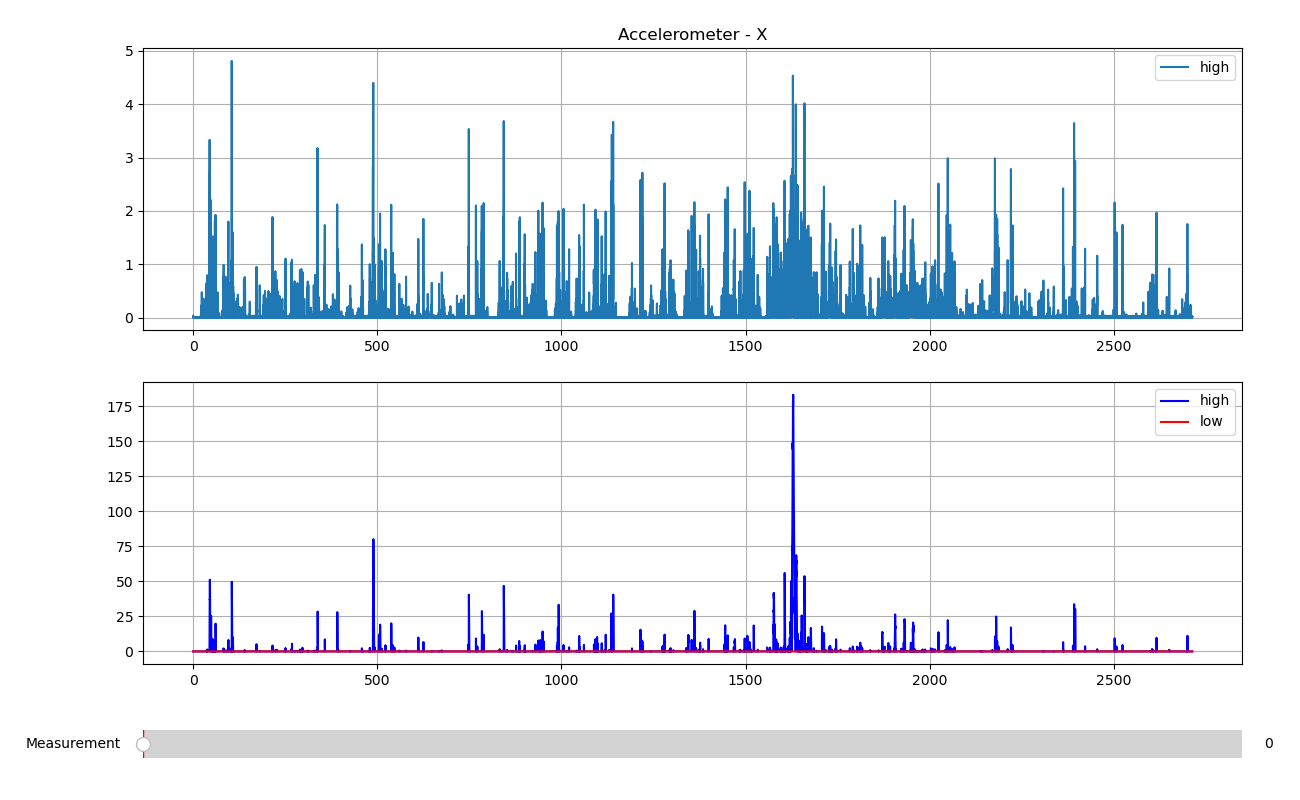

In [4]:
critical_level_threshold = 0.5

def high_cusum(x):
    Sh = np.zeros(len(x))
    mean = np.average(x)
    for i in range(1,len(x)):
        Sh[i] = max(Sh[i-1] + x[i] - critical_level_threshold, 0)
    return Sh
        
def low_cusum(x):
    Sl = np.zeros(len(x))
    mean = np.average(x)
    for i in range(1,len(x)):
        Sl[i] = max(Sl[i-1] - x[i] - critical_level_threshold, 0)
    return Sl

cusum_high_data = enveloped_data.transform(high_cusum, [['accel', 'x'], ['accel', 'y'], ['accel', 'z'],
                                                        ['gyro',  'x'],  ['gyro', 'y'],  ['gyro', 'z']], in_place=False)
cusum_low_data  = enveloped_data.transform(low_cusum,  [['accel', 'x'], ['accel', 'y'], ['accel', 'z'],
                                                        ['gyro',  'x'],  ['gyro', 'y'],  ['gyro', 'z']], in_place=False)


# PLOTTING
cusum_fig = plt.figure(2)
cusum_fig.clear()
gs_kw = dict(height_ratios=[0.5, 0.5, 0.1])
cusum_fig, cusum_ax = plt.subplot_mosaic(num=2, mosaic=[['envelope'],
                                                        ['cusum'],
                                                        ['slider']], gridspec_kw=gs_kw)

measurement_slider = Slider(ax=cusum_ax['slider'], label='Measurement', 
                            valmin=0, 
                            valmax=5, 
                            valinit=0, 
                            valstep=1)
data_path_list = [['accel','x'], ['accel','y'], ['accel','z'], ['gyro','x'], ['gyro','y'], ['gyro','z']]

def change_plot(idx):
    cusum_ax['envelope'].clear()
    cusum_ax['cusum'].clear()

    cusum_ax['envelope'].plot(enveloped_data['time']['rel'], get_by_path(enveloped_data, data_path_list[idx]))
    cusum_ax['envelope'].grid(which='both', axis='both')
    cusum_ax['envelope'].legend(['high','low'])

    cusum_ax['cusum'].plot(cusum_high_data['time']['rel'], get_by_path(cusum_high_data, data_path_list[idx]), color='b', label='high')
    cusum_ax['cusum'].plot(cusum_low_data['time']['rel'],  get_by_path(cusum_low_data,  data_path_list[idx]), color='r', label='low')
    cusum_ax['cusum'].grid(which='both', axis='both')
    cusum_ax['cusum'].legend()
    cusum_ax['cusum'].sharex(cusum_ax['envelope'])

    if idx < 3:
        measurement = 'Accelerometer'
    else:
        measurement = 'Gyroscope'

    if idx % 3 == 0:
        title = measurement + ' - X'
    elif idx % 3 == 1:
        title = measurement + ' - Y'
    else:
        title = measurement + ' - Z'
    cusum_ax['envelope'].set_title(title)

change_plot(0)
measurement_slider.on_changed(change_plot)

cusum_fig.set_size_inches(13, 8)
cusum_fig.tight_layout(pad=2.0)

plt.show()

### CUSUM charts on **standardized** envelope data

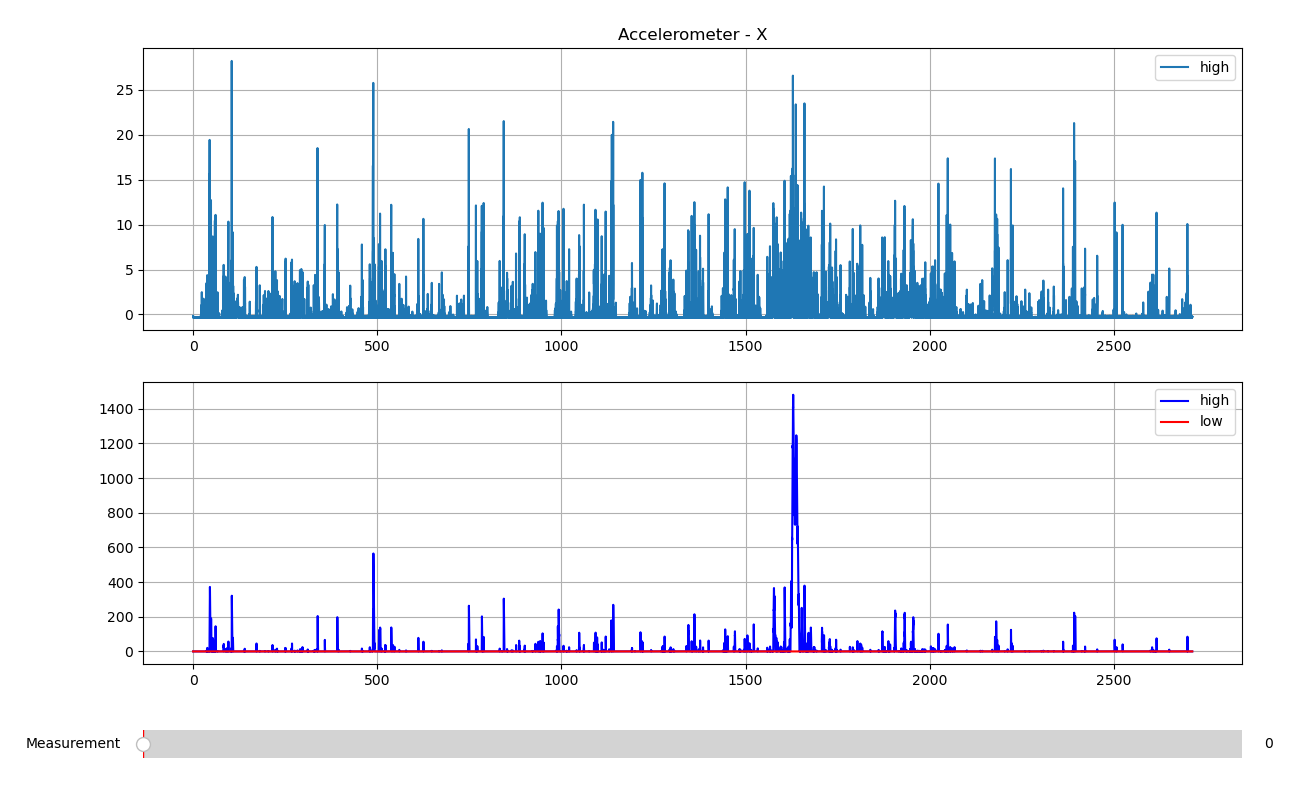

In [5]:
critical_level_threshold = 2

def high_cusum_norm(x):
    Sh = np.zeros(len(x))
    mean = np.average(x)
    std = np.std(x)
    for i in range(1,len(x)):
        Sh[i] = max(Sh[i-1] + (x[i] - mean) / std - critical_level_threshold, 0)
    return Sh
        
def low_cusum_norm(x):
    Sl = np.zeros(len(x))
    mean = np.average(x)
    std = np.std(x)
    for i in range(1,len(x)):
        Sl[i] = max(Sl[i-1] - (x[i] - mean) / std - critical_level_threshold, 0)
    return Sl

cusum_norm_high_data = enveloped_data.transform(high_cusum_norm, [['accel', 'x'], ['accel', 'y'], ['accel', 'z'],
                                                                  ['gyro',  'x'],  ['gyro', 'y'],  ['gyro', 'z']], in_place=False)
cusum_norm_low_data  = enveloped_data.transform(low_cusum_norm,  [['accel', 'x'], ['accel', 'y'], ['accel', 'z'],
                                                                  ['gyro',  'x'],  ['gyro', 'y'],  ['gyro', 'z']], in_place=False)


# PLOTTING
cusum_norm_fig = plt.figure(3)
cusum_norm_fig.clear()
gs_kw = dict(height_ratios=[0.5, 0.5, 0.1])
cusum_norm_fig, cusum_norm_ax = plt.subplot_mosaic(num=3, mosaic=[['envelope'],
                                                                  ['cusum'],
                                                                  ['slider']], gridspec_kw=gs_kw)

measurement_slider = Slider(ax=cusum_norm_ax['slider'], label='Measurement', 
                            valmin=0, 
                            valmax=5, 
                            valinit=0, 
                            valstep=1)
data_path_list = [['accel','x'], ['accel','y'], ['accel','z'], ['gyro','x'], ['gyro','y'], ['gyro','z']]

def change_plot(idx):
    cusum_norm_ax['envelope'].clear()
    cusum_norm_ax['cusum'].clear()

    cusum_norm_ax['envelope'].plot(norm_envelope_data['time']['rel'], get_by_path(norm_envelope_data, data_path_list[idx]))
    cusum_norm_ax['envelope'].grid(which='both', axis='both')
    cusum_norm_ax['envelope'].legend(['high','low'])

    cusum_norm_ax['cusum'].plot(cusum_norm_high_data['time']['rel'], get_by_path(cusum_norm_high_data, data_path_list[idx]), color='b', label='high')
    cusum_norm_ax['cusum'].plot(cusum_norm_low_data['time']['rel'],  get_by_path(cusum_norm_low_data,  data_path_list[idx]), color='r', label='low')
    cusum_norm_ax['cusum'].grid(which='both', axis='both')
    cusum_norm_ax['cusum'].legend()
    cusum_norm_ax['cusum'].sharex(cusum_norm_ax['envelope'])

    if idx < 3:
        measurement = 'Accelerometer'
    else:
        measurement = 'Gyroscope'

    if idx % 3 == 0:
        title = measurement + ' - X'
    elif idx % 3 == 1:
        title = measurement + ' - Y'
    else:
        title = measurement + ' - Z'
    cusum_norm_ax['envelope'].set_title(title)

change_plot(0)
measurement_slider.on_changed(change_plot)

cusum_norm_fig.set_size_inches(13, 8)
cusum_norm_fig.tight_layout(pad=2.0)

plt.show()

### Standardize envelope data

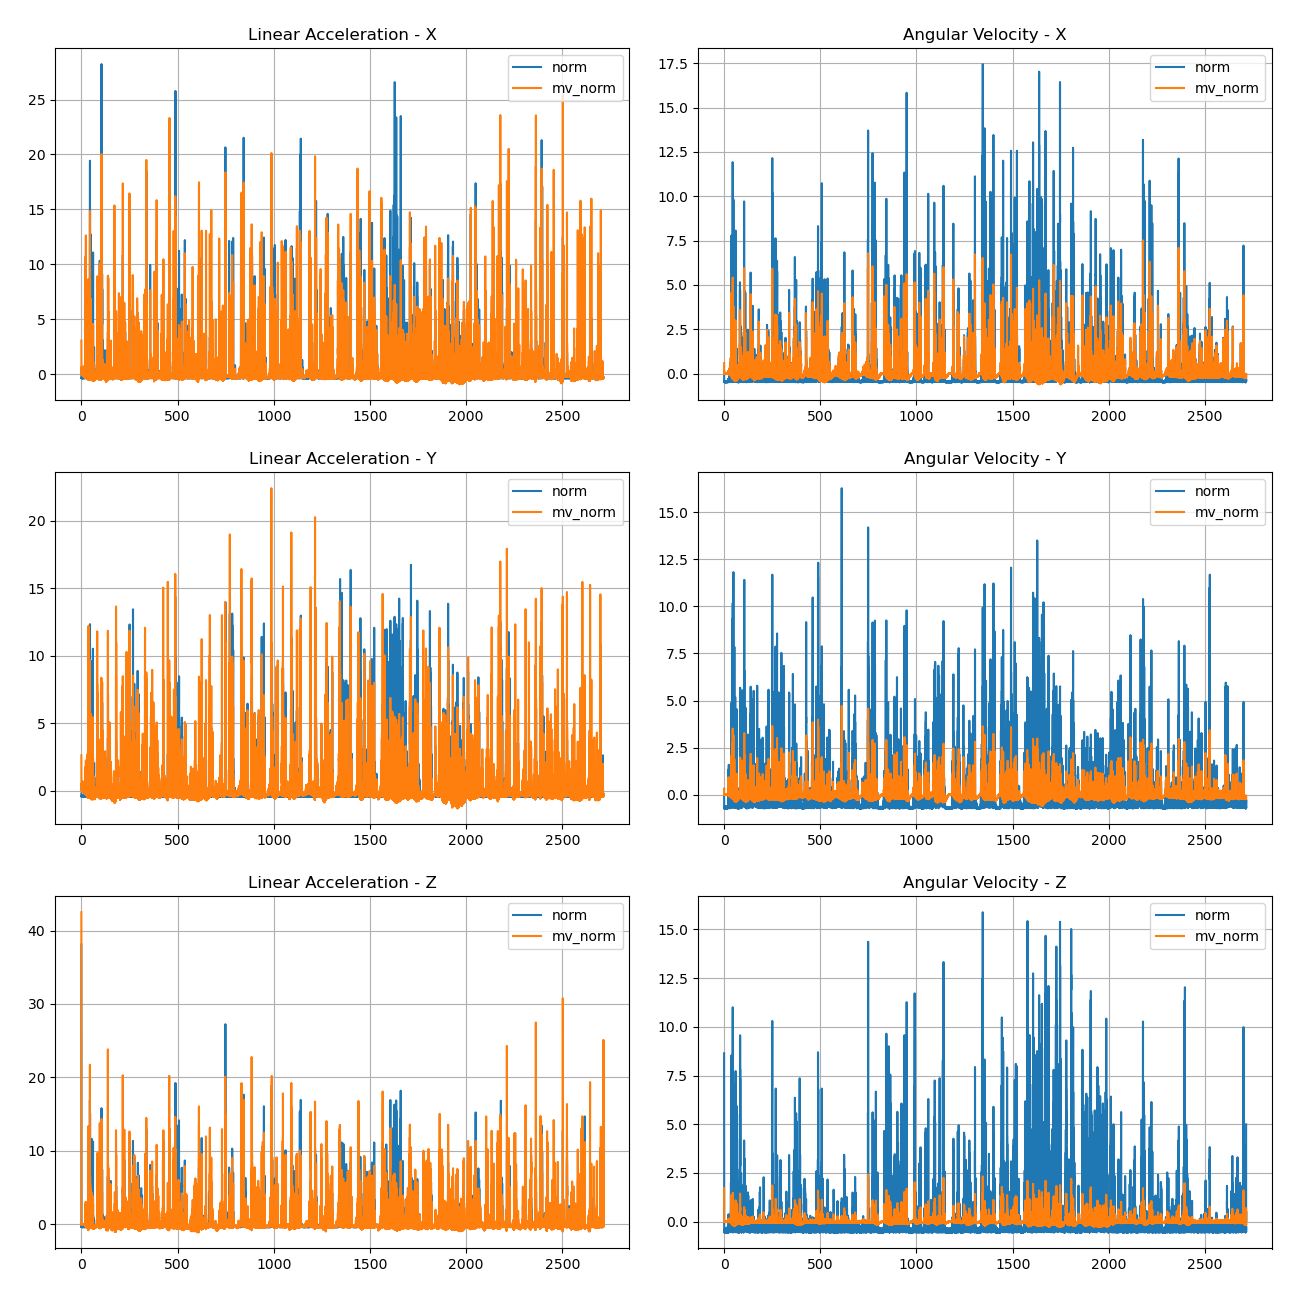

In [6]:
# Whole-data standardization
normalize_mean_std_fun = lambda x: (x - np.average(x)) / np.std(x)
normalized_data = enveloped_data.transform(normalize_mean_std_fun, [['accel', 'x'], ['accel', 'y'], ['accel', 'z'],
                                                                    ['gyro',  'x'],  ['gyro', 'y'],  ['gyro', 'z']], in_place=False)

# Moving window standardization
moving_window_length = 2000
normalize_moving_mean_std_fun = lambda x: (x - signal_filter.moving_average(x, moving_window_length)) / (signal_filter.moving_std(x, moving_window_length) + 1e-2)
moving_normalized_data = enveloped_data.transform(normalize_moving_mean_std_fun, [['accel', 'x'], ['accel', 'y'], ['accel', 'z'],
                                                                                  ['gyro',  'x'],  ['gyro', 'y'],  ['gyro', 'z']], in_place=False)

# PLOTTING
stand_ax_x_lim = None
stand_ax_y_lim = None
if 'stand_ax' in locals():
    stand_ax_x_lim = stand_ax[0][0].get_xlim()
    stand_ax_y_lim = stand_ax[0][0].get_ylim()

stand_fig = plt.figure(10)
stand_fig.clear()
stand_fig, stand_ax = plt.subplots(num=10, nrows=3, ncols=2, sharex='all')

stand_ax[0][0].plot(normalized_data['time']['rel'], normalized_data['accel']['x'], label='norm')
stand_ax[0][0].plot(moving_normalized_data['time']['rel'], moving_normalized_data['accel']['x'], label='mv_norm')
stand_ax[0][0].grid(which='both', axis='both')
stand_ax[0][0].legend(loc='upper right')
stand_ax[0][0].tick_params(labelbottom=True)
stand_ax[0][0].set_title('Linear Acceleration - X')

stand_ax[1][0].plot(normalized_data['time']['rel'], normalized_data['accel']['y'], label='norm')
stand_ax[1][0].plot(moving_normalized_data['time']['rel'], moving_normalized_data['accel']['y'], label='mv_norm')
stand_ax[1][0].grid(which='both', axis='both')
stand_ax[1][0].legend(loc='upper right')
stand_ax[1][0].tick_params(labelbottom=True)
stand_ax[1][0].set_title('Linear Acceleration - Y')

stand_ax[2][0].plot(normalized_data['time']['rel'], normalized_data['accel']['z'], label='norm')
stand_ax[2][0].plot(moving_normalized_data['time']['rel'], moving_normalized_data['accel']['z'], label='mv_norm')
stand_ax[2][0].grid(which='both', axis='both')
stand_ax[2][0].legend(loc='upper right')
stand_ax[2][0].tick_params(labelbottom=True)
stand_ax[2][0].set_title('Linear Acceleration - Z')

stand_ax[0][1].plot(normalized_data['time']['rel'], normalized_data['gyro']['x'], label='norm')
stand_ax[0][1].plot(moving_normalized_data['time']['rel'], moving_normalized_data['gyro']['x'], label='mv_norm')
stand_ax[0][1].grid(which='both', axis='both')
stand_ax[0][1].legend(loc='upper right')
stand_ax[0][1].tick_params(labelbottom=True)
stand_ax[0][1].set_title('Angular Velocity - X')

stand_ax[1][1].plot(normalized_data['time']['rel'], normalized_data['gyro']['y'], label='norm')
stand_ax[1][1].plot(moving_normalized_data['time']['rel'], moving_normalized_data['gyro']['y'], label='mv_norm')
stand_ax[1][1].grid(which='both', axis='both')
stand_ax[1][1].legend(loc='upper right')
stand_ax[1][1].tick_params(labelbottom=True)
stand_ax[1][1].set_title('Angular Velocity - Y')

stand_ax[2][1].plot(normalized_data['time']['rel'], normalized_data['gyro']['z'], label='norm')
stand_ax[2][1].plot(moving_normalized_data['time']['rel'], moving_normalized_data['gyro']['z'], label='mv_norm')
stand_ax[2][1].grid(which='both', axis='both')
stand_ax[2][1].legend(loc='upper right')
stand_ax[2][1].tick_params(labelbottom=True)
stand_ax[2][1].set_title('Angular Velocity - Z')

stand_fig.set_size_inches(13,13)
stand_fig.tight_layout(pad=2)

if (stand_ax_x_lim is not None) and (stand_ax_y_lim is not None):
    stand_ax[0][0].set_xlim(stand_ax_x_lim)
    stand_ax[0][0].set_ylim(stand_ax_y_lim)
    
stand_fig.canvas.mpl_connect('key_press_event', lambda event: figure_reset_scale(event, stand_ax[0][0]))

plt.show()